# COVID-19 Clusters Mapping

The Metro Public Health Department tracks COVID-19 clusters. The files `clusters.csv` and `clusters_by_type.csv` contain the tables of clusters as reported by [WSMV](https://www.wsmv.com/news/metro-health-releases-latest-covid-19-clusters/article_ef554e08-1558-11eb-b290-873345e174d7.html) along with the coordinates of the clusters. Can you find any connection between the reported COVID violations and subsequent COVID clusters?

In [28]:
# import statements
import pandas as pd
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import rasterio
from rasterio.plot import show as rioshow
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from cartopy.io import shapereader
import os
%matplotlib inline

In [2]:
# display settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Read in a base map of Davidson County, parsed by zipcode

In [3]:
davidson = gpd.read_file('../data/zipcodes.geojson')
print(davidson.crs)
davidson.head()

epsg:4326


,zip,objectid,po_name,shape_stlength,shape_starea,geometry
0,37115,1,MADISON,178783.02488886821,596553400.57885742,"MULTIPOLYGON (((-86.68725 36.31821, -86.68722 ..."
1,37216,3,NASHVILLE,75820.997821400058,188884682.28344727,"MULTIPOLYGON (((-86.73451 36.23774, -86.73425 ..."
2,37204,9,NASHVILLE,93180.292250425613,200664795.51708984,"MULTIPOLYGON (((-86.77914 36.13424, -86.77923 ..."
3,37027,11,BRENTWOOD,159760.6942933173,174978422.04101562,"MULTIPOLYGON (((-86.81258 36.06319, -86.81263 ..."
4,37064,18,FRANKLIN,28995.828320601937,46969608.005737305,"MULTIPOLYGON (((-87.02197 36.01200, -87.02140 ..."


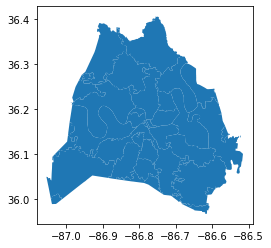

In [4]:
sour.plot();

In [5]:
davidson.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Create some geo dataframes to map things

In [6]:
violations_by_loc = pd.read_csv('../data/violations_by_loc.csv')

In [7]:
violations_by_loc.head()

,long,lat,address,request_no
0,-86.782000,36.163000,210 Anne Dallas Dudley Blvd,268
1,-86.774605,36.195731,21B Fern Ave,112
2,-86.782343,36.170861,717 3rd Ave N,38
3,-86.774621,36.195585,21A Fern Ave,32
4,-86.778476,36.167262,1 Public Sq,28


In [8]:
# Create a geopandas dataframe based on the violations data, grouped by location
violations_by_loc_geo = gpd.GeoDataFrame(
    violations_by_loc, crs = davidson.crs, geometry = gpd.points_from_xy(violations_by_loc.long, violations_by_loc.lat))

# Make sure it worked
violations_by_loc_geo.head()

,long,lat,address,request_no,geometry
0,-86.782000,36.163000,210 Anne Dallas Dudley Blvd,268,POINT (-86.78200 36.16300)
1,-86.774605,36.195731,21B Fern Ave,112,POINT (-86.77461 36.19573)
2,-86.782343,36.170861,717 3rd Ave N,38,POINT (-86.78234 36.17086)
3,-86.774621,36.195585,21A Fern Ave,32,POINT (-86.77462 36.19558)
4,-86.778476,36.167262,1 Public Sq,28,POINT (-86.77848 36.16726)


In [9]:
violations_by_loc_geo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
violations_by_zip = gpd.sjoin(violations_by_loc_geo, davidson, op = 'within')

In [11]:
violations_by_zip.head()

,long,lat,address,request_no,geometry,index_right,zip,objectid,po_name,shape_stlength,shape_starea
0,-86.782000,36.163000,210 Anne Dallas Dudley Blvd,268,POINT (-86.78200 36.16300),24,37219,15,NASHVILLE,21013.192337432083,6579013.4385986328
23,-86.781602,36.162664,Nashville,12,POINT (-86.78160 36.16266),24,37219,15,NASHVILLE,21013.192337432083,6579013.4385986328
40,-86.780408,36.164083,226 5th Ave N,10,POINT (-86.78041 36.16408),24,37219,15,NASHVILLE,21013.192337432083,6579013.4385986328
49,-86.778967,36.164202,210 4th Ave N,8,POINT (-86.77897 36.16420),24,37219,15,NASHVILLE,21013.192337432083,6579013.4385986328
67,-86.781618,36.163828,511 Union St,7,POINT (-86.78162 36.16383),24,37219,15,NASHVILLE,21013.192337432083,6579013.4385986328


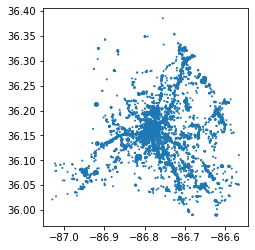

In [12]:
violations_by_zip.plot(markersize = 'request_no');

In [37]:
print(ctx.providers.keys())


dict_keys(['OpenStreetMap', 'OpenSeaMap', 'OpenPtMap', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Thunderforest', 'OpenMapSurfer', 'Hydda', 'MapBox', 'Stamen', 'Esri', 'OpenWeatherMap', 'HERE', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'Wikimedia', 'GeoportailFrance', 'OneMapSG'])


In [36]:
print(ctx.providers.OpenStreetMap.keys())

dict_keys(['Mapnik', 'DE', 'CH', 'France', 'HOT', 'BZH'])


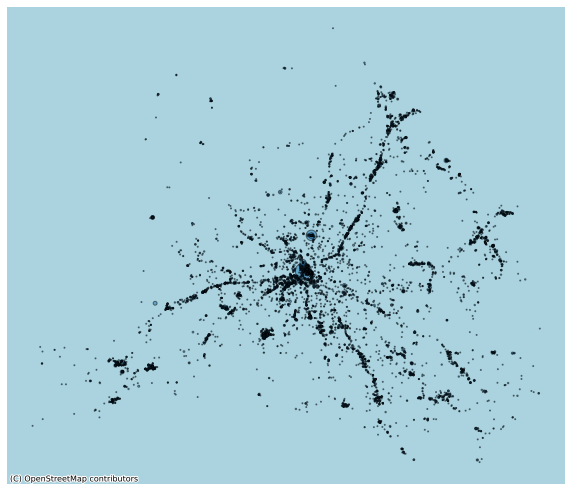

In [35]:
ax = violations_by_zip.plot(markersize = 'request_no', figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, zoom=12, source = ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off();

In [13]:
violations_by_loc_and_date = pd.read_csv('../data/violations_by_loc_and_date.csv')
violations_by_loc_and_date

,long,lat,address,date_opened,request_no
0,-86.774605,36.195731,21B Fern Ave,2020-08-02,68
1,-86.774605,36.195731,21B Fern Ave,2020-08-03,32
2,-86.774621,36.195585,21A Fern Ave,2020-08-02,17
3,-86.774621,36.195585,21A Fern Ave,2020-08-03,11
4,-86.782000,36.163000,210 Anne Dallas Dudley Blvd,2020-07-14,9
...,...,...,...,...,...
10462,-86.789170,36.119190,3021 Lealand Ln,2020-06-01,1
10463,-86.789156,36.118830,1000 Clayton Ave,2020-09-06,1
10464,-86.789156,36.118830,3000 Granny White Pike,2020-04-11,1
10465,-86.789155,36.124974,2506 12th Ave S,2020-09-29,1


In [14]:
# Create a geopandas dataframe based on the cleaned-up violations dataframe by day
violations_by_loc_and_date_geo = gpd.GeoDataFrame(
    violations_by_loc_and_date, crs = davidson.crs, geometry = gpd.points_from_xy(violations_by_loc_and_date.long, violations_by_loc_and_date.lat))

In [15]:
# violations_by_date_pivoted = pd.pivot_table(violations_by_loc_and_date, values = 'request_no',
#                                            index = ['long', 'lat', 'address'], columns = 'date_opened', aggfunc = np.sum).reset_index()
# violations_by_date_pivoted

In [17]:
# print(violations_by_date_pivoted.columns.tolist())

In [18]:
# # save all the maps in the charts folder
# output_path = '../visualizations'

# # counter for the for loop
# i = 0

# # list of years (which are the column names at the moment)
# list_of_days = ['2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01',
#                 '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05', 
#                 '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09', 
#                 '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13', 
#                 '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17', 
#                 '2020-04-18', '2020-04-19', '2020-04-20', '2020-04-21', 
#                 '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25', 
#                 '2020-04-26', '2020-04-27', '2020-04-28', '2020-04-29', 
#                 '2020-04-30', '2020-05-01', '2020-05-02', '2020-05-03', 
#                 '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07', 
#                 '2020-05-08', '2020-05-09', '2020-05-10', '2020-05-11', 
#                 '2020-05-12', '2020-05-13', '2020-05-14', '2020-05-15', 
#                 '2020-05-16', '2020-05-17', '2020-05-18', '2020-05-19', 
#                 '2020-05-20', '2020-05-21', '2020-05-22', '2020-05-23', 
#                 '2020-05-24', '2020-05-25', '2020-05-26', '2020-05-27', 
#                 '2020-05-28', '2020-05-29', '2020-05-30', '2020-05-31', 
#                 '2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04', 
#                 '2020-06-05', '2020-06-06', '2020-06-07', '2020-06-08', 
#                 '2020-06-09', '2020-06-10', '2020-06-11', '2020-06-12', 
#                 '2020-06-13', '2020-06-14', '2020-06-15', '2020-06-16', 
#                 '2020-06-17', '2020-06-18', '2020-06-19', '2020-06-20', 
#                 '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24', 
#                 '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28', 
#                 '2020-06-29', '2020-06-30', '2020-07-01', '2020-07-02', 
#                 '2020-07-03', '2020-07-04', '2020-07-05', '2020-07-06', 
#                 '2020-07-07', '2020-07-08', '2020-07-09', '2020-07-10', 
#                 '2020-07-11', '2020-07-12', '2020-07-13', '2020-07-14', 
#                 '2020-07-15', '2020-07-16', '2020-07-17', '2020-07-18', 
#                 '2020-07-19', '2020-07-20', '2020-07-21', '2020-07-22', 
#                 '2020-07-23', '2020-07-24', '2020-07-25', '2020-07-26', 
#                 '2020-07-27', '2020-07-28', '2020-07-29', '2020-07-30', 
#                 '2020-07-31', '2020-08-01', '2020-08-02', '2020-08-03', 
#                 '2020-08-04', '2020-08-05', '2020-08-06', '2020-08-07', 
#                 '2020-08-08', '2020-08-09', '2020-08-10', '2020-08-11', 
#                 '2020-08-12', '2020-08-13', '2020-08-14', '2020-08-15', 
#                 '2020-08-16', '2020-08-17', '2020-08-18', '2020-08-19', 
#                 '2020-08-20', '2020-08-21', '2020-08-22', '2020-08-23', 
#                 '2020-08-24', '2020-08-25', '2020-08-26', '2020-08-27', 
#                 '2020-08-28', '2020-08-29', '2020-08-30', '2020-08-31', 
#                 '2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04', 
#                 '2020-09-05', '2020-09-06', '2020-09-07', '2020-09-08', 
#                 '2020-09-09', '2020-09-10', '2020-09-11', '2020-09-12', 
#                 '2020-09-13', '2020-09-14', '2020-09-15', '2020-09-16', 
#                 '2020-09-17', '2020-09-18', '2020-09-19', '2020-09-20', 
#                 '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24', 
#                 '2020-09-25', '2020-09-26', '2020-09-27', '2020-09-28', 
#                 '2020-09-29', '2020-09-30', '2020-10-01', '2020-10-02', 
#                 '2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06', 
#                 '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10', 
#                 '2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14', 
#                 '2020-10-15', '2020-10-16', '2020-10-17', '2020-10-18', 
#                 '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22', 
#                 '2020-10-23', '2020-10-24', '2020-10-25', '2020-10-26', 
#                 '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30', 
#                 '2020-10-31', '2020-11-01', '2020-11-02', '2020-11-03', 
#                 '2020-11-04', '2020-11-05']

In [19]:
# # set the min and max range for the choropleth map
# vmin, vmax = 200, 1200

In [20]:
# # Create a geopandas dataframe based on the cleaned-up violations pivoted dataframe
# violations_by_date_pivoted_geo = gpd.GeoDataFrame(
#     violations_by_date_pivoted, crs = davidson.crs, geometry = gpd.points_from_xy(violations_by_date_pivoted.long, violations_by_date_pivoted.lat))


In [21]:
violations_by_date = gpd.sjoin(violations_by_loc_and_date_geo, davidson, op = 'within')

In [22]:
violations_by_date.head()

,long,lat,address,date_opened,request_no,geometry,index_right,zip,objectid,po_name,shape_stlength,shape_starea
0,-86.774605,36.195731,21B Fern Ave,2020-08-02,68,POINT (-86.77461 36.19573),42,37207,48,NASHVILLE,196775.60104082408,556772811.32653809
1,-86.774605,36.195731,21B Fern Ave,2020-08-03,32,POINT (-86.77461 36.19573),42,37207,48,NASHVILLE,196775.60104082408,556772811.32653809
2,-86.774621,36.195585,21A Fern Ave,2020-08-02,17,POINT (-86.77462 36.19558),42,37207,48,NASHVILLE,196775.60104082408,556772811.32653809
3,-86.774621,36.195585,21A Fern Ave,2020-08-03,11,POINT (-86.77462 36.19558),42,37207,48,NASHVILLE,196775.60104082408,556772811.32653809
15,-86.803206,36.235362,3301 Knight Dr,2020-10-26,5,POINT (-86.80321 36.23536),42,37207,48,NASHVILLE,196775.60104082408,556772811.32653809


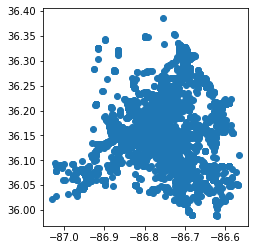

In [23]:
violations_by_date.plot(markersize = 'request_no');

In [ ]:
# DO NOT RUN THIS, IT WILL RUN OUT OF MEMORY (though it does work)
# # start the for loop to create one map per year
# for day in list_of_days:
    
#     # create map, UDPATE: added plt.Normalize to keep the legend range the same for all maps
#     fig = violations_by_date.plot(column='date_opened', cmap='Blues', figsize=(10,10), linewidth=0.8, edgecolor='0.8', vmin=vmin, vmax=vmax,
# legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    
#     # remove axis of chart
#     fig.axis('off')
    
#     # add a title
#     fig.set_title('Violent crimes in London', \
#               fontdict={'fontsize': '25',
#                          'fontweight' : '3'})
    
#     # this will save the figure as a high-res png in the output path. you can also save as svg if you prefer.
#     filepath = os.path.join(output_path, str(i)+'_violations.jpg')
#     chart = fig.get_figure()
#     chart.savefig(filepath, dpi=150)

In [ ]:
# DO NOT USE THIS - IT WILL CAUSE JUPYTER NOTEBOOKS TO CRASH
# # Get the centerpoint for Davidson county
# center = davidson.geometry.centroid[42]

# area_center = [center.y, center.x]
# # Draw Davidson county map with violations
# davidson_map = folium.Map(location = area_center, zoom_start = 9)

# folium.GeoJson(violations_by_zip).add_to(davidson_map)

# #iterate through stops_in_37207 to create locations and markers 
# #for each bus stop
# #remember for Folium locations, lat is listed first!!

# for row_index, row_values in violations_by_zip.iterrows():
#     loc = [row_values['lat'], row_values['long']]
#     pop = str(row_values['request_no'])
#     marker = folium.Marker(
#         location = loc, 
#         popup = pop) 
    
#     marker.add_to(davidson_map)
# davidson_map.save('../visualizations/violations_by_loc_map.html')

# #display our map
# davidson_map

In [39]:
# If using the full violations dataset
# violations_geo = violations_geo.drop(['datetime_opened', 'address', 'city', 'zip', 'lat', 'long', 'coord'], axis = 1)

In [40]:
# # Set the CRS
# violations_geo = violations_geo.set_crs(epsg=4326)
# print(violations_geo.crs)

In [41]:
# violations_geo.info()

In [47]:
clusters = pd.read_csv('../data/clusters_cleaned.csv')

In [117]:
clusters.head()

,Unnamed: 0,cluster_name,type,start_date,case_count,lat,long,geometry
0,0,Vanderbilt Parties,Social Gathering,2020-03-11,49,36.144703,-86.802655,POINT (-86.80266 36.14470)
1,1,Event at Clementine Hall,Social Gathering,2020-03-14,23,36.152444,-86.844583,POINT (-86.84458 36.15244)
2,2,Religious Retreat,Social Gathering,2020-03-25,18,NaN,NaN,POINT (nan nan)
3,3,The Health Center at Richland Place,LTCF,2020-04-03,47,36.128750,-86.817345,POINT (-86.81734 36.12875)
4,4,Trevecca Center for Rehab and Healing,LTCF,2020-04-04,102,36.144562,-86.754560,POINT (-86.75456 36.14456)


In [118]:
clusters.describe()

,Unnamed: 0,case_count,lat,long
count,62.000000,62.000000,51.000000,51.000000
mean,30.500000,45.048387,36.143962,-86.784064
std,18.041619,50.018170,0.059617,0.080127
min,0.000000,10.000000,36.035223,-86.971542
25%,15.250000,15.000000,36.103078,-86.820805
50%,30.500000,24.000000,36.149592,-86.780929
75%,45.750000,49.000000,36.172106,-86.734056
max,61.000000,280.000000,36.331015,-86.647347


In [49]:
# Create a geopandas dataframe based on the cleaned-up clusters dataframe
clusters_geo = gpd.GeoDataFrame(
    clusters, crs = davidson.crs, geometry = gpd.points_from_xy(clusters.long, clusters.lat))

# Make sure it worked
clusters_geo.head()

,Unnamed: 0,cluster_name,type,start_date,case_count,lat,long,geometry
0,0,Vanderbilt Parties,Social Gathering,2020-03-11,49,36.144703,-86.802655,POINT (-86.80266 36.14470)
1,1,Event at Clementine Hall,Social Gathering,2020-03-14,23,36.152444,-86.844583,POINT (-86.84458 36.15244)
2,2,Religious Retreat,Social Gathering,2020-03-25,18,NaN,NaN,POINT (nan nan)
3,3,The Health Center at Richland Place,LTCF,2020-04-03,47,36.128750,-86.817345,POINT (-86.81734 36.12875)
4,4,Trevecca Center for Rehab and Healing,LTCF,2020-04-04,102,36.144562,-86.754560,POINT (-86.75456 36.14456)


In [50]:
clusters_geo = clusters_geo.drop(['lat', 'long'], axis = 1)

In [51]:
clusters_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Unnamed: 0    62 non-null     int64   
 1   cluster_name  62 non-null     object  
 2   type          62 non-null     object  
 3   start_date    62 non-null     object  
 4   case_count    62 non-null     int64   
 5   geometry      62 non-null     geometry
dtypes: geometry(1), int64(2), object(3)
memory usage: 3.0+ KB


In [52]:
# Join the clusters and violations data to the base map of Davidson County
violations_by_zip = gpd.sjoin(violations_by_loc_geo, davidson, op = 'within')

In [53]:
violations_by_zip.head()

,long,lat,address,request_no,geometry,index_right,zip,objectid,po_name,shape_stlength,shape_starea
0,-86.782000,36.163000,210 Anne Dallas Dudley Blvd,268,POINT (-86.78200 36.16300),24,37219,15,NASHVILLE,21013.192337432083,6579013.4385986328
23,-86.781602,36.162664,Nashville,12,POINT (-86.78160 36.16266),24,37219,15,NASHVILLE,21013.192337432083,6579013.4385986328
40,-86.780408,36.164083,226 5th Ave N,10,POINT (-86.78041 36.16408),24,37219,15,NASHVILLE,21013.192337432083,6579013.4385986328
49,-86.778967,36.164202,210 4th Ave N,8,POINT (-86.77897 36.16420),24,37219,15,NASHVILLE,21013.192337432083,6579013.4385986328
67,-86.781618,36.163828,511 Union St,7,POINT (-86.78162 36.16383),24,37219,15,NASHVILLE,21013.192337432083,6579013.4385986328


In [54]:
# Quick cleanup
violations_by_zip = violations_by_zip.rename(columns = {'request_no' : 'total_violations'})
violations_by_zip = violations_by_zip.drop('index_right', axis = 1)
violations_by_zip.head()

,long,lat,address,total_violations,geometry,zip,objectid,po_name,shape_stlength,shape_starea
0,-86.782000,36.163000,210 Anne Dallas Dudley Blvd,268,POINT (-86.78200 36.16300),37219,15,NASHVILLE,21013.192337432083,6579013.4385986328
23,-86.781602,36.162664,Nashville,12,POINT (-86.78160 36.16266),37219,15,NASHVILLE,21013.192337432083,6579013.4385986328
40,-86.780408,36.164083,226 5th Ave N,10,POINT (-86.78041 36.16408),37219,15,NASHVILLE,21013.192337432083,6579013.4385986328
49,-86.778967,36.164202,210 4th Ave N,8,POINT (-86.77897 36.16420),37219,15,NASHVILLE,21013.192337432083,6579013.4385986328
67,-86.781618,36.163828,511 Union St,7,POINT (-86.78162 36.16383),37219,15,NASHVILLE,21013.192337432083,6579013.4385986328


In [84]:
counts_by_business = pd.read_csv('../data/counts_by_business.csv')
counts_by_business

,address,business_name,lat,long,request_no
0,210 Anne Dallas Dudley Blvd,Hakdog Resto Bar,36.163000,-86.782000,268
1,717 3rd Ave N,Jonathan's Grille,36.170861,-86.782343,38
2,1 Public Sq,Davidson County Jury Duty,36.167262,-86.778476,28
3,333 Commerce St,Littler Mendelson P.C.,36.162544,-86.776781,24
4,Broadway,Honky Tonk Highway,36.156583,-86.787453,23
...,...,...,...,...,...
6637,2547 Nashville Hwy,J P Custom Flooring,35.709498,-86.975275,1
6638,2542 Lebanon Pike,"4EverEcig - Delta 8, Vapes, Headshop, Kratom",36.170113,-86.676257,1
6639,2541 Murfreesboro Rd,Taco Bell,36.076485,-86.641316,1
6640,2540 Lebanon Pike,Shipley Do-Nuts,36.170053,-86.676377,1


In [88]:
top_violations = counts_by_business.head(100)
top_violations

,address,business_name,lat,long,request_no
0,210 Anne Dallas Dudley Blvd,Hakdog Resto Bar,36.163000,-86.782000,268
1,717 3rd Ave N,Jonathan's Grille,36.170861,-86.782343,38
2,1 Public Sq,Davidson County Jury Duty,36.167262,-86.778476,28
3,333 Commerce St,Littler Mendelson P.C.,36.162544,-86.776781,24
4,Broadway,Honky Tonk Highway,36.156583,-86.787453,23
5,711 Gallatin Ave,MoneyGram,36.184381,-86.747059,20
6,1200 Donelson Ave,Chopper's Grill,36.264297,-86.651201,20
7,221 Broadway,Kid Rock's Big Ass Honky Tonk Rock N' Roll Ste...,36.161446,-86.775726,19
8,2408 Music Valley Dr,Scoreboard Bar & Grill,36.218237,-86.697950,18
9,5838 River Rd,Harpeth Valley Utilities District,36.133598,-86.917717,15


In [89]:
# Create a geopandas dataframe based on the cleaned-up clusters dataframe
top_violations_geo = gpd.GeoDataFrame(
    top_violations, crs = davidson.crs, geometry = gpd.points_from_xy(top_violations.long, top_violations.lat))

# Make sure it worked
top_violations_geo.head()

,address,business_name,lat,long,request_no,geometry
0,210 Anne Dallas Dudley Blvd,Hakdog Resto Bar,36.163000,-86.782000,268,POINT (-86.78200 36.16300)
1,717 3rd Ave N,Jonathan's Grille,36.170861,-86.782343,38,POINT (-86.78234 36.17086)
2,1 Public Sq,Davidson County Jury Duty,36.167262,-86.778476,28,POINT (-86.77848 36.16726)
3,333 Commerce St,Littler Mendelson P.C.,36.162544,-86.776781,24,POINT (-86.77678 36.16254)
4,Broadway,Honky Tonk Highway,36.156583,-86.787453,23,POINT (-86.78745 36.15658)


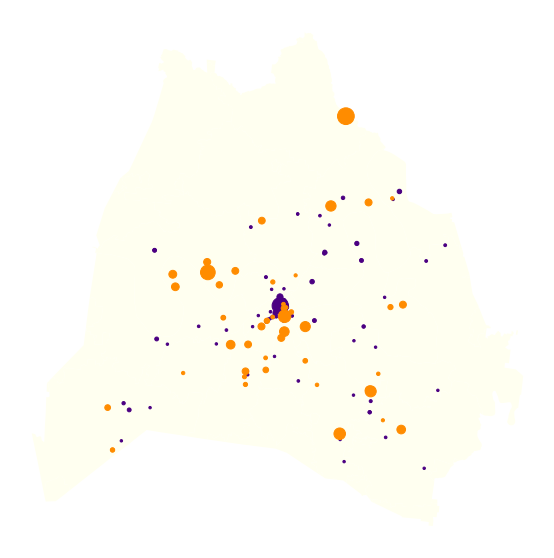

In [91]:
ax = davidson.plot(figsize = (10, 10), color = 'ivory')
top_violations_geo.plot(ax = ax, markersize = top_violations_geo['request_no'], color = 'indigo', legend = True)
clusters_by_zip.plot(ax = ax, markersize = clusters_by_zip['case_count'], color = 'darkorange')
plt.axis('off')
plt.savefig('../visualizations/clusters_and_top_violations_mapped.png', dpi=150, transparent = True);

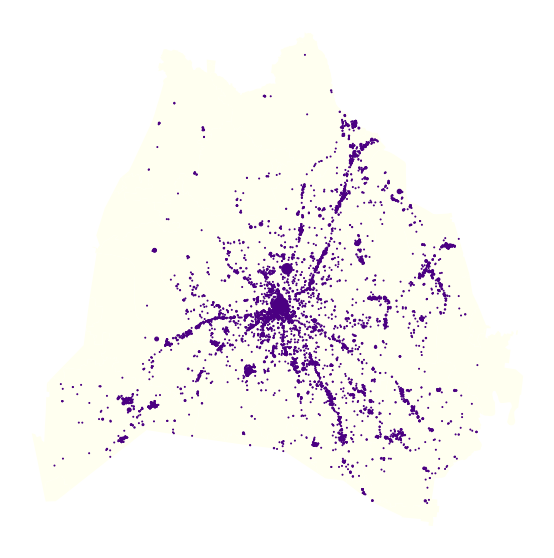

In [61]:
# Violations mapped by zip
ax = davidson.plot(figsize = (10, 10), color = 'ivory')
violations_by_zip.plot(ax = ax, markersize = violations_by_zip['total_violations'], color = 'indigo', legend = True)
plt.axis('off')
plt.savefig('../visualizations/violations_mapped.png', dpi=150, transparent = True);

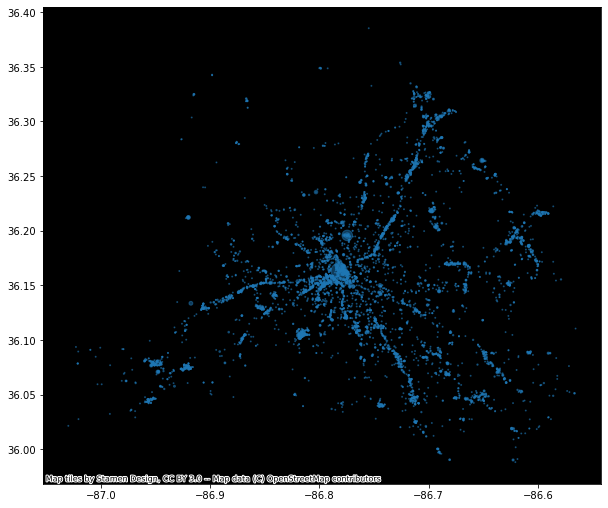

In [56]:
# Another attempt to get a decent basemap
ax = violations_by_zip.plot(figsize = (10, 10), alpha = 0.5, markersize = violations_by_zip['total_violations'])
ctx.add_basemap(ax, source = ctx.providers.Stamen.Toner, zoom = 12)

In [ ]:
# Let's try folium
covid_map = folium.Map(
    location=[36.1627, -86.7816],
    tiles='Stamen Toner',
    zoom_start=11
)

In [ ]:
# # DON'T RUN ME, I WILL CRASH THE NOTEBOOK
# for row_index, row_values in violations_by_zip.iterrows():
#     loc = [row_values['lat'], row_values['long']]
#     pop = str(row_values['total_violations'])
#     marker = folium.Marker(
#         location = loc, 
#         popup = pop) 
    
#     marker.add_to(covid_map)
# covid_map.save('..covid_map.html')

# #display the map
# covid_map

In [62]:
clusters_by_zip = gpd.sjoin(clusters_geo, davidson, op = 'within')
clusters_by_zip.head()

,Unnamed: 0,cluster_name,type,start_date,case_count,geometry,index_right,zip,objectid,po_name,shape_stlength,shape_starea
0,0,Vanderbilt Parties,Social Gathering,2020-03-11,49,POINT (-86.80266 36.14470),39,37240,36,NASHVILLE,7052.8091646713856,2841889.5506591797
1,1,Event at Clementine Hall,Social Gathering,2020-03-14,23,POINT (-86.84458 36.15244),12,37209,10,NASHVILLE,310224.91345860378,1001364029.2892456
48,48,Lois DeBerry Special Needs Facility,Correctional Facility,2020-09-01,62,POINT (-86.90004 36.19093),12,37209,10,NASHVILLE,310224.91345860378,1001364029.2892456
49,49,Riverbend Max Security Prison-2,Correctional Facility,2020-09-01,60,POINT (-86.89721 36.17984),12,37209,10,NASHVILLE,310224.91345860378,1001364029.2892456
3,3,The Health Center at Richland Place,LTCF,2020-04-03,47,POINT (-86.81734 36.12875),32,37205,16,NASHVILLE,146801.80831498865,400978073.00933838


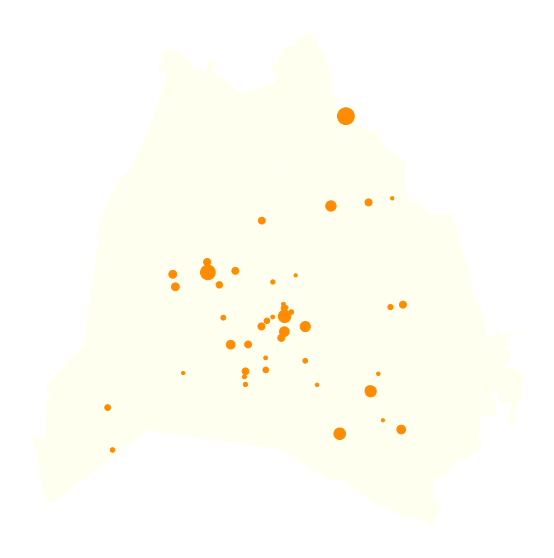

In [69]:
ax = davidson.plot(figsize = (10, 10), color = 'ivory')
clusters_by_zip.plot(ax = ax, markersize = clusters_by_zip['case_count'], color = 'darkorange')
plt.axis('off')
plt.savefig('../visualizations/clusters_mapped.png', dpi=150, transparent = True);

In [80]:
clusters.type.unique()

array(['Social Gathering', 'LTCF', 'Commercial-Warehouse',
       'Correctional Facility', 'Congregate Living', 'Other',
       'Construction', 'Bar', 'Restaurant', 'Office',
       'College / University', 'School', 'Church', 'Gym'], dtype=object)

In [92]:
LTCF_clusters = clusters[clusters['type'] == 'LTCF']

In [104]:
LTCF_clusters_geo = gpd.GeoDataFrame(
    LTCF_clusters, crs = davidson.crs, geometry = gpd.points_from_xy(LTCF_clusters.long, LTCF_clusters.lat))
LTCF_clusters_geo

,Unnamed: 0,cluster_name,type,start_date,case_count,lat,long,geometry
3,3,The Health Center at Richland Place,LTCF,2020-04-03,47,36.128750,-86.817345,POINT (-86.81734 36.12875)
4,4,Trevecca Center for Rehab and Healing,LTCF,2020-04-04,102,36.144562,-86.754560,POINT (-86.75456 36.14456)
6,6,Nashville Center for Rehab and Healing,LTCF,2020-04-08,12,36.134557,-86.780929,POINT (-86.78093 36.13456)
8,8,Bordeaux,LTCF,2020-04-15,47,36.193945,-86.831388,POINT (-86.83139 36.19394)
10,10,Bethany Center for Rehab and Healing,LTCF,2020-04-27,133,36.049614,-86.716761,POINT (-86.71676 36.04961)
11,11,Knowles Assisted Living,LTCF,2020-04-27,41,36.181554,-86.848928,POINT (-86.84893 36.18155)
16,16,Good Samaritan Health & Healing,LTCF,2020-06-03,75,36.053331,-86.649235,POINT (-86.64924 36.05333)
18,18,The Opal at Music City,LTCF,2020-06-03,27,36.161851,-86.661030,POINT (-86.66103 36.16185)
21,21,Creekside Center for Rehab and Healing,LTCF,2020-06-15,107,36.251458,-86.726428,POINT (-86.72643 36.25146)
24,24,West Meade Place,LTCF,2020-06-24,11,36.103424,-86.888650,POINT (-86.88865 36.10342)


In [105]:
correctional_clusters = clusters[clusters['type'] == 'Correctional Facility']

In [106]:
correctional_clusters_geo = gpd.GeoDataFrame(
    correctional_clusters, crs = davidson.crs, geometry = gpd.points_from_xy(correctional_clusters.long, correctional_clusters.lat))
correctional_clusters_geo

,Unnamed: 0,cluster_name,type,start_date,case_count,lat,long,geometry
7,7,CDM Jail,Correctional Facility,2020-04-13,22,36.088200,-86.683980,POINT (-86.68398 36.08820)
26,26,CDM Jail,Correctional Facility,2020-06-26,75,36.088200,-86.683980,POINT (-86.68398 36.08820)
44,44,CoreCivic,Correctional Facility,2020-08-04,122,36.087183,-86.682728,POINT (-86.68273 36.08718)
48,48,Lois DeBerry Special Needs Facility,Correctional Facility,2020-09-01,62,36.190930,-86.900036,POINT (-86.90004 36.19093)
49,49,Riverbend Max Security Prison-2,Correctional Facility,2020-09-01,60,36.179843,-86.897212,POINT (-86.89721 36.17984)
50,50,Debra Johnson Rehab/TN Prison for Women,Correctional Facility,2020-09-01,216,36.192596,-86.861519,POINT (-86.86152 36.19260)


TypeError: cannot convert the series to <class 'float'>

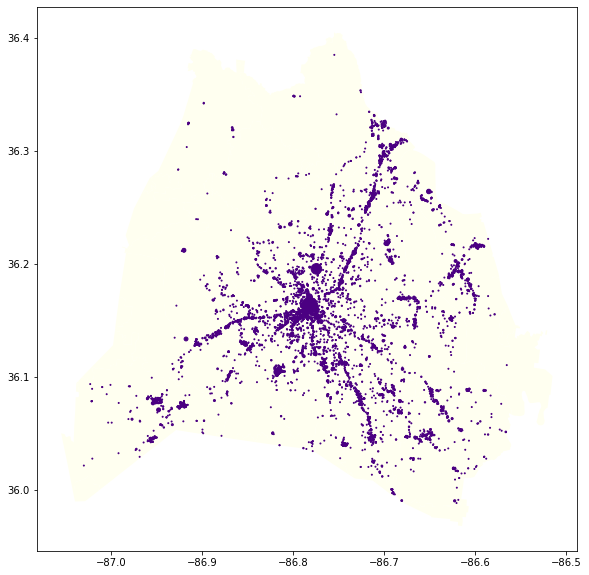

In [107]:
ax = davidson.plot(figsize = (10, 10), color = 'ivory')
violations_by_zip.plot(ax = ax, markersize = violations_by_zip['total_violations'], color = 'indigo', legend = True)
correctional_clusters.plot(ax = ax, markersize = correctional_clusters['case_count'], color = 'darkorange')
plt.axis('off')
plt.savefig('../visualizations/LTCF_clusters_and_all_violations_mapped.png', dpi=150, transparent = True);

In [82]:
# # Trying to get colors per type
# colors = {'Social Gathering' : 'firebrick', 'LTCF' : 'darksalmon',
#           'Commercial-Warehouse' : 'sandybrown', 'Correctional Facility' : 'olivedrab',
#           'Congregate Living' : 'mediumturquoise', 'Other' : 'cadetblue',
#           'Construction' : 'darkblue', 'Bar' : 'purple',
#           'Restaurant' : 'black', 'Office' : 'palevioletred',
#           'College / University' : 'darkcyan', 'School' : 'crimson',
#           'Church' : 'coral', 'Gym' : 'saddlebrown'}
# ax = davidson.plot(figsize = (10, 10), color = 'ivory')
# clusters_by_zip.plot(ax = ax, markersize = clusters_by_zip['case_count'], color = colors)
# plt.axis('off')
# plt.colorbar()
# plt.savefig('../visualizations/clusters_mapped_colored.png', dpi=150, transparent = True);

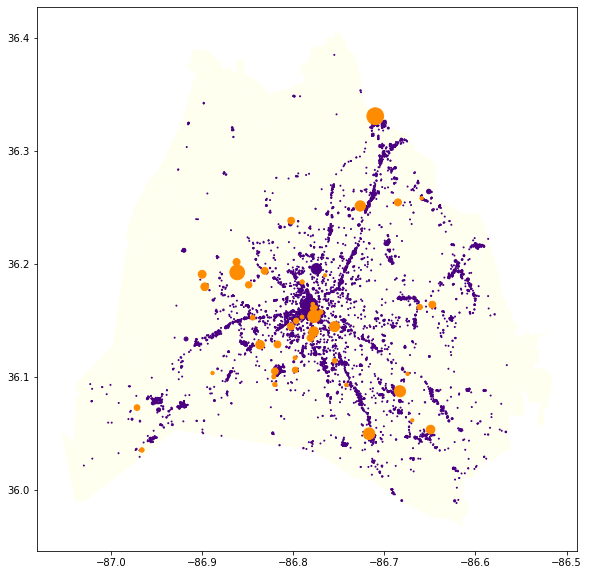

In [109]:
ax = davidson.plot(figsize = (10, 10), color = 'ivory')
violations_by_zip.plot(ax = ax, markersize = violations_by_zip['total_violations'], color = 'indigo', legend = True)
clusters_by_zip.plot(ax = ax, markersize = clusters_by_zip['case_count'], color = 'darkorange')
# plt.axis('off')
plt.savefig('../visualizations/clusters_and_violations_mapped.png', dpi=150, transparent = True);

In [97]:
clusters

,Unnamed: 0,cluster_name,type,start_date,case_count,lat,long,geometry
0,0,Vanderbilt Parties,Social Gathering,2020-03-11,49,36.144703,-86.802655,POINT (-86.80266 36.14470)
1,1,Event at Clementine Hall,Social Gathering,2020-03-14,23,36.152444,-86.844583,POINT (-86.84458 36.15244)
2,2,Religious Retreat,Social Gathering,2020-03-25,18,NaN,NaN,POINT (nan nan)
3,3,The Health Center at Richland Place,LTCF,2020-04-03,47,36.128750,-86.817345,POINT (-86.81734 36.12875)
4,4,Trevecca Center for Rehab and Healing,LTCF,2020-04-04,102,36.144562,-86.754560,POINT (-86.75456 36.14456)
5,5,Tyson Foods,Commercial-Warehouse,2020-04-06,280,36.331015,-86.709977,POINT (-86.70998 36.33101)
6,6,Nashville Center for Rehab and Healing,LTCF,2020-04-08,12,36.134557,-86.780929,POINT (-86.78093 36.13456)
7,7,CDM Jail,Correctional Facility,2020-04-13,22,36.088200,-86.683980,POINT (-86.68398 36.08820)
8,8,Bordeaux,LTCF,2020-04-15,47,36.193945,-86.831388,POINT (-86.83139 36.19394)
9,9,Cargill,Commercial-Warehouse,2020-04-21,22,36.114254,-86.754589,POINT (-86.75459 36.11425)


In [116]:
outliers = clusters[(clusters['long'] < -86.84) & (clusters['lat'] > 36.15)]
outliers.sort_values(by='lat')

,Unnamed: 0,cluster_name,type,start_date,case_count,lat,long,geometry
1,1,Event at Clementine Hall,Social Gathering,2020-03-14,23,36.152444,-86.844583,POINT (-86.84458 36.15244)
49,49,Riverbend Max Security Prison-2,Correctional Facility,2020-09-01,60,36.179843,-86.897212,POINT (-86.89721 36.17984)
11,11,Knowles Assisted Living,LTCF,2020-04-27,41,36.181554,-86.848928,POINT (-86.84893 36.18155)
48,48,Lois DeBerry Special Needs Facility,Correctional Facility,2020-09-01,62,36.190930,-86.900036,POINT (-86.90004 36.19093)
50,50,Debra Johnson Rehab/TN Prison for Women,Correctional Facility,2020-09-01,216,36.192596,-86.861519,POINT (-86.86152 36.19260)
34,34,Standing Tall Music City,Congregate Living,2020-07-01,50,36.201781,-86.862279,POINT (-86.86228 36.20178)


TypeError: cannot convert the series to <class 'float'>

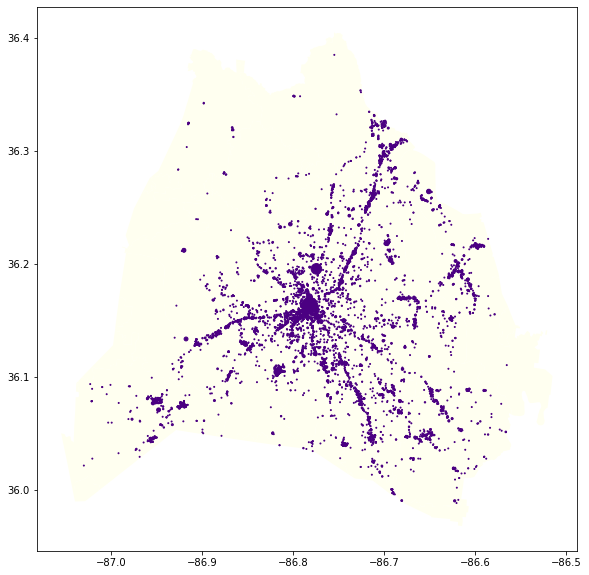

In [103]:
ax = davidson.plot(figsize = (10, 10), color = 'ivory')
violations_by_zip.plot(ax = ax, markersize = violations_by_zip['total_violations'], color = 'indigo', legend = True)
outliers.plot(ax = ax, markersize = outliers['case_count'], color = 'darkorange')
# plt.axis('off')
# plt.savefig('../visualizations/clusters_and_violations_mapped.png', dpi=150, transparent = True);

### Join the two maps together

In [38]:
clusters_and_violations_geo = clusters_by_zip.append(violations_by_zip)
clusters_and_violations_geo.info()

NameError: name 'clusters_by_zip' is not defined

In [ ]:
clusters_and_violations_geo.head()

In [ ]:
ax = davidson.plot(figsize = (10, 10), color = 'cadetblue')
clusters_and_violations_geo.plot(ax = ax, markersize = ['case_count', 'total_violations'], color = ['ivory', 'red']);